In [1]:
# !pip3 install -q -r requirements.txt

In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import gymnasium as gym
import numpy as np
import time

from collections import deque

from IPython import display
import imageio
import os
FP = './animations'
# !pipreqsnb --force

## [Proceed to results](#results)

In [2]:
ENV = gym.make("Taxi-v3", render_mode="rgb_array")
N_STATES = ENV.observation_space.n # 25 taxi positions * 5 passenger locations * 4 destinations
N_ACTIONS = ENV.action_space.n
ACTIONS_STR = ('^','v','<','>','p','d') # for taxi policy visualization

In [3]:
def rr(env=ENV, capture=False):
    """quick render fix assuming env's render_mode='rgb_array' """
    arr = env.render()
    if capture:
        return arr
    else:
        plt.axis('off')
        plt.imshow(arr)
               
def act(action, env=ENV):
    """filters unnecessary output"""
    return env.step(action)[:3]

In [4]:
class AnnealingRate:
    def __init__(self, start=0.5, n_iterations=100, drop=0):
        self.str_name = 'Constant rate'
        self.start = start
        self.drop = drop
        self.n_total = n_iterations

    def __call__(self, i):
        return [self.start] * self.n_total
        
    def plot(self, n_iterations=100, ax=None):
        if hasattr(self, "__call__") and callable(self.__call__):
            i = np.arange(n_iterations)
            ax = sns.lineplot(self.__call__(i), linewidth=1, ax=ax)
            ax.xaxis.set_major_locator(MaxNLocator(integer=True))
            ax.set_title(f"{self.str_name}", fontsize=15)
            ax.set_xlabel('iterations - 1')
            return ax
        else:
            raise NotImplementedError

class LinearAR(AnnealingRate):
    """Linear decay from start to zero"""
    def __init__(self, n_iterations=100, start=1, drop=0, thr=0):
        super().__init__(n_iterations=n_iterations, start=start, drop=drop)
        self.str_name = 'Linear decay'

    def __call__(self, i):
        return self.start * (1 - i / (self.n_total - 1))
        
class ExponentialAR(AnnealingRate):
    """exponential decay with i --> +inf, provides descending values within range [expl_thr, start],
        la=0.01 means ~36% left after 100 iterations, results < drop value are zeroed"""
    def __init__(self, la, n_iterations=100, start=1, drop=1e-7, thr=0):
        super().__init__(n_iterations=n_iterations, start=start, drop=drop)
        self.str_name = 'Exponential decay'
        self.thr = thr
        self.la = la

    def __call__(self, i):
        result = self.thr + (self.start - self.thr) * np.exp(- self.la * i)
        if self.drop:
            if isinstance(i, np.ndarray):
                result[result <= self.drop] = 0
            elif result < self.drop:
                result = 0
        return result

class SigmoidalAR(AnnealingRate):
    """symmetric sigmoidal decay within [0, 2*mid-1] provides descending values within range [1-alpha, alpha], 
        results < drop value are zeroed, alpha controls the gap between function value and its asymptotes (i=1/i=0)"""
    def __init__(self, al, n_iterations=100, start=1, drop=1e-7, thr=0):
        super().__init__(n_iterations=n_iterations, start=start, drop=drop)
        self.str_name = 'Sigmoidal decay'
        self.thr = thr
        self.al = al

    def __call__(self, i):
        # establish max possible smoothness given alpha and symmetrize wrt mid value (this form has been pre-simplified)
        mid = self.n_total//2
        result = self.start * (1 + (1/self.al - 1) ** ((i - mid)/mid) )**(-1)
        if self.drop:
            if isinstance(i, np.ndarray):
                result[result <= self.drop] = 0
            elif result < self.drop:
                result = 0 
        return result

class SteppingAR(AnnealingRate):
    """Stepping decay from start to zero, given by percent values of value and size"""
    def __init__(self, n_iterations=100, start=1, drop=0, steps=((100, 20), (50, 40), (25, 20), (0, 20))):
        super().__init__(n_iterations=n_iterations, start=start, drop=drop)
        self.str_name = 'Stepping decay'
        assert np.array(steps)[:, 1].sum() == 100, f'wrong steps {steps}'
        self.stepping = []
        for (pv, s) in steps:
            self.stepping += [start*pv/100]*(int(n_iterations*s/100))
        self.stepping = np.array(self.stepping)

    def __call__(self, i):
        return self.stepping[i]

class AntiExponentialAR(ExponentialAR):
    """slow exponential rise with i --> +inf, provides ascending values within range [expl_thr, start],
        la=0.01 means ~36% left after 100 iterations, results < drop value are zeroed"""

    def __init__(self, la, n_iterations=100, end=1, drop=1e-7, thr=0):
        super().__init__(n_iterations=n_iterations, la=la, start=end, drop=drop, thr=thr)
        self.str_name = 'Slow exponential decay'

    def __call__(self, i):
        return 1 - super().__call__(i)

In [5]:
class RandAgent:
    """baseline agent that performs random (sample from uniform distr) actions"""
    def __init__(self, n_states=N_STATES, n_actions=N_ACTIONS, aid_to_str=ACTIONS_STR, capture_path=FP):
        self.n_states = n_states
        self.n_actions = n_actions
        self.aid_to_str = aid_to_str # action symbols (to be shown on policy graph)
        self.log = [] # container for anything related to learning process (to be shown on a graph)
        self.rendered_frames = None # container for rendered images (numpy arrays) used by '.capture' method
        self.capture_path = capture_path
        self.fly = None # some method to be executed throughout a trajectory (e.g. change policy based on local MDP context)
        self.policy = np.ones((self.n_states, self.n_actions))/self.n_actions # uniform policy initialisation (sa)
        
    def act(self, state):
        """draws a random sample from current distribution on actions"""
        action = np.random.choice(self.n_actions, p=self.policy[state]) # outputs integers thus doesn't require .item()
        return action

    def walk(self, max_length, render=False, **interkwargs):
        """perform max_length actions by agent N"""
        states, actions, rewards = [], [], []
        state = ENV.reset()[0] # initial state
        q6 = deque(maxlen=6) # prepare a fixed-size queue as 2-step MDP (sarsar) storage
        for i in range(max_length):
            # perform an action
            action = self.act(state)
            new_state, reward, done = act(action)
            # log 
            states.append(state) # append OLD state, everything breaks if you start from new
            actions.append(action)
            rewards.append(reward)
            # add (append) current step (sar) to queue
            q6.extend((state, action, reward))
            state = new_state
            if interkwargs and self.fly:
                try:
                    self.fly(q6, **interkwargs)
                except AttributeError:
                    print("intermediary update method hasn't been defined for this class")
            # continuous visualization w/ proper interrupt
            if render:
                try:
                    if render == 2:
                        arr = rr(capture=True)
                        self.rendered_frames.append(arr)
                    else:
                        rr()
                        display.display(plt.gcf())
                        time.sleep(1e-4)
                        display.clear_output(wait=True)
                except KeyboardInterrupt:
                    break
            if done:
                break
        trajectory = {'s': states,
                        'a': actions,
                            'r': rewards,}
        return trajectory
        
    ### VISUALIZATION ###    
    def capture(self, max_length, fps=30, fpath=FP):
        """captures render output and creates gif animation from frames (rgb arrays)"""
        self.rendered_frames = []
        results = self.walk(max_length, render=2)
        name = ENV.unwrapped.spec.id + '.gif'
        path = os.path.join(fpath, name)
        imageio.mimsave(path, ims=self.rendered_frames, fps=fps)
        print(f"Trajectory with reward {sum(results['r'])} has been captured to {path}")

    def learning_curve(self, title="", label="", logscale=False, show_max=True, ax=None):
        """plots log vs iterations of algorithm"""
        ax = sns.lineplot(self.log, linewidth=1.0, ax=ax, label=label)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.set_title(title, fontsize = 10)
        ax.set_xlabel('iterations - 1')
        if logscale:
            ax.set_yscale('symlog')
        if show_max:
            ax.axhline(y=max(self.log), color='r', linestyle='-', linewidth=0.5)
        return ax

    def show_policy(self, label=None):
        """plots current policy matrix as a heatmap"""
        plt.figure(figsize=(2, 5))
        concise_actions = {'xticklabels': self.aid_to_str} if self.aid_to_str else {}
        ax = sns.heatmap(self.policy, **concise_actions, cbar=False)
        ax.set_title(label if label else 'Current policy')
        return ax
        
class CrossEntropyAgent(RandAgent):
    """CrossEntropy algorithm actor, optimizes expected reward by policy"""
    def __init__(self):
        super().__init__()
        
    def fit(self, n_iterations, n_trajectories=700, max_length=950, q=0.7, la=None, lr=0.95, verbose=None):
        """
        CE Algorithm has 2 steps per iteration: evaluate policy, improve policy
        Our goal is to maximize expected reward ER which is unreachable => approximated
        
        n_trajectories (length <= max_length) defines quality of ER approximation
        0<q<1 controls rejected quantile of trajectories
        
        la>0 controls (and enables) Laplace policy smoothing
        lr>0 controls (and enables) exponential policy smoothing (interpreted as learning rate)

        verbose>0 sets up a period of learning process rendering
        """

        for i in range(n_iterations):
            # policy evaluation (act with current policy)
            trajectories = [self.walk(max_length=max_length) for t in range(n_trajectories)]
            rewards = np.stack([np.sum(t['r']) for t in trajectories])
            avg_reward = np.mean(rewards)
            self.log.append(avg_reward)
            # policy improvement
            gamma = np.quantile(rewards, q) # get q-quantile of current reward distribution and filter out better trajectories
            elite_ids = (rewards > gamma).nonzero()[0]
            # redistribute actions at each state according to these results (put higher weights)
            if elite_ids.any():
                dummy = np.zeros_like(self.policy)
                for ei in elite_ids:
                    et = trajectories[ei]
                    # count number of occurrences for all pairs s-a, all trajectories
                    dummy[et['s'], et['a']] += 1
                occurrences_of_states = dummy.sum(axis=1, keepdims=True)
                occurrences_of_states[occurrences_of_states==0] = 1E-2 # prevent zero division error AND populate with sth>0 in case dummy's row has all zeros
                # involves broadcasting, la or lr turn on smoothing if provided
                new_policy = (dummy + la)/(occurrences_of_states + la*self.n_actions) if la else dummy/occurrences_of_states
                policy_ = lr * new_policy + (1 - lr) * self.policy if lr else new_policy + self.policy
                # normalize (make new rows sum up to 1)
                self.policy = policy_/policy_.sum(axis=1, keepdims=True)
                
            # visualization
            if verbose and i > 0 and (i + 1) % verbose == 0:
                plt.close() # because plt.clf() is spurious
                ax = self.learning_curve(title=f"Mean rewards over {n_trajectories} trajectories of length < {max_length}", label=f'lr={lr}', logscale=True)
                # self.show_policy(label=f"Agent's policy after {i+1} iterations")
                display.display(plt.gcf())
                display.clear_output(wait=True)
        return avg_reward

class ModelFreeAgent(RandAgent):
    """Model-free agent == R, TP functions of ENV aren't provided and aren't (explicitly?) approximated"""
    def __init__(self):
        super().__init__()
        self.stc = 0 # counts improvement steps 

    def gpi(self, q, eps, zero_mask=None):
        """epsilon-greedy policy improvement based on values of q(s,a), at each state,
        policy ~ not only take an action that maximizes given action-value function q, 
        but also allow "the rest' actions happen with eps probability (shared)
        
        unvisited states have q=0 but that doesn't matter anything, 
        as rewards are < 0, such states would impact argmax in vain,
        zero_mask removes them from computation"""
        if zero_mask is not None:
            q[zero_mask] = np.full(shape=q.shape, fill_value=-10)[zero_mask]
            # q = np.ma.array(q, mask=zero_mask)
        # epsilon-greedy: let eps be ~"the rest' actions probability, split it between the all actions
        dummy = (1 - eps + eps / self.n_actions) * np.eye(self.n_actions) + (eps / self.n_actions) * (np.ones(self.n_actions) - np.eye(self.n_actions))
        best_actions = np.argmax(q, axis=0) # 1D array of 'best' actions
        # one-hot encoding of best_actions array (used to choose rows from dummy)
        self.policy = dummy[best_actions]
        self.stc += 1

    def fit(self, n_trajectories, max_length, alpha_d=0.5, gamma=0.99, eps_d=None, verbose=False):
        dh = display.display(display_id=True)
        eps_rates, alpha_rates = [], []
        if callable(alpha_d):
            alpha_d.n_total = n_trajectories
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)
        for i, t in enumerate(range(n_trajectories)):
            # decrease eps throughout the loop
            eps = eps_d(i)
            # decrease alpha ~ learning rate
            alpha = alpha_d(i) if callable(alpha_d) else alpha_d
            # policy evaluation and improvement throughout trajectory
            results = self.walk(max_length=max_length, alpha=alpha, eps=eps, gamma=gamma)
            # visualization
            eps_rates.append(eps)
            alpha_rates.append(alpha)
            self.log.append(sum(results['r']))
            # self.log.append(np.sum(self.q))
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", logscale=True)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                ax2 = sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε‎", color='blueviolet')
                sns.lineplot(alpha_rates, linewidth=0.5, ax=ax2, label="learning rate, α", color='orchid')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

5.638571428571429

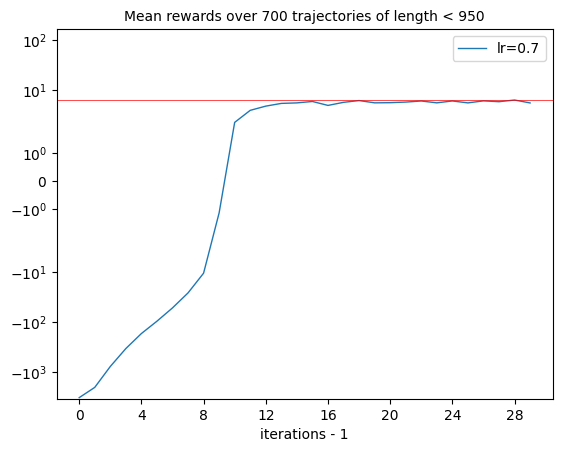

In [9]:
cea = CrossEntropyAgent()
cea.fit(n_iterations=30, verbose=1, lr=0.7)

In [6]:
class SARSAAgent(ModelFreeAgent):
    """SARSA updates at each step of every trajectory"""
    def __init__(self):
        super().__init__()
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.sarsa_step

    def sarsa_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy in sarsa manner"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx, ax = list(queue_6)[:5]
            self.Q[a, s] += alpha * (r + gamma * self.Q[ax, sx] - self.Q[a, s])
            self.gpi(self.Q, eps)

class QLearningAgent(ModelFreeAgent):
    """Q updates at each step of every trajectory"""
    def __init__(self):
        super().__init__()
        self.Q = np.zeros_like(self.policy.T)
        self.fly = self.ql_step

    def ql_step(self, queue_6, alpha, eps, gamma):
        """accepts a queue object, updates value-function q and policy ~ Q-learning"""
        if len(queue_6) == 6: # sarsar
            s, a, r, sx = list(queue_6)[:4]
            self.Q[a, s] += alpha * (r + gamma * np.max(self.Q[:, sx]) - self.Q[a, s])
            self.gpi(self.Q, eps)

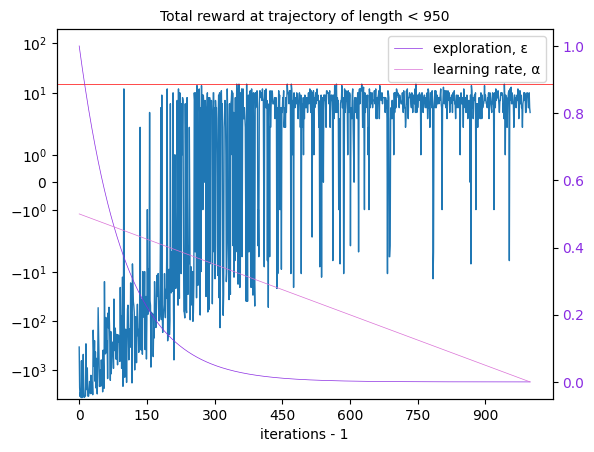

In [12]:
sarsa = SARSAAgent()
ann_sarsa_a = LinearAR(start=0.5)
ann_sarsa_e = ExponentialAR(la=1e-2)
sarsa.fit(n_trajectories=1000, max_length=950, alpha_d=ann_sarsa_a, eps_d=ann_sarsa_e, gamma=0.9999, verbose=True)

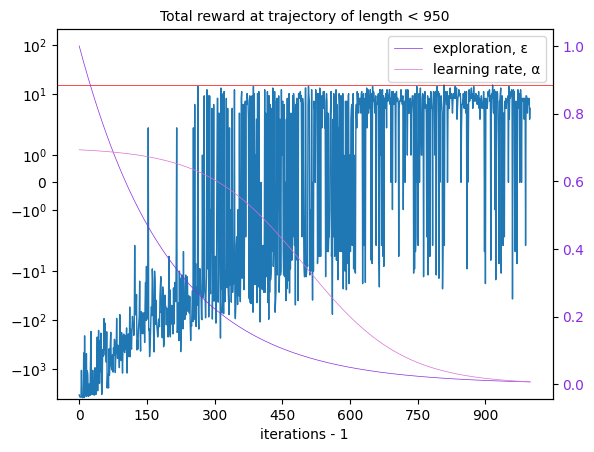

In [25]:
qlr = QLearningAgent()
# ann_qlr_a = LinearAR(start=0.5)
# ann_qlr_a = ExponentialAR(la=0.1, start=0.8)
ann_qlr_a = SigmoidalAR(al=1e-2, start=0.7)
ann_qlr_e = ExponentialAR(la=5e-3)
qlr.fit(n_trajectories=1000, max_length=950, alpha_d=ann_qlr_a, eps_d=ann_qlr_e, gamma=0.9999, verbose=True)

In [7]:
class MonteCarloAgent(ModelFreeAgent):
    """Applies Monte-Carlo sampling of trajectories for action-value function q approximation"""
    def __init__(self):
        super().__init__()

    # def walk_gn_test(self, gamma, max_length):
    #     """transforms standard results after tracing a route"""
    #     Q = np.zeros_like(self.policy.T)
    #     N = np.zeros_like(self.policy.T)
    #     trajectory = super().walk(max_length=max_length)
    #     R, A, S = trajectory['r'], trajectory['a'], trajectory['s']
    #     # get summands of rewards serie (w/ discounting)
    #     gamma_ = np.cumprod(np.concatenate((np.atleast_1d(1.), np.tile(np.array(gamma), len(R) - 1))))
    #     R_discounted = gamma_ * np.array(R)
    #     # get values of G as if we'd started at timestep t (aka returns)
    #     G = np.array([np.sum(R_discounted[t:]) / gamma**t for t in range(len(R_discounted))])
    #     for t, (r, a, s) in enumerate(zip(R,A,S)):
    #         Q[a, s] += (G[t] - Q[a, s])/(N[a,s] + 1)
    #         N[a, s] += 1
    #     return Q*N, N, sum(R)

    
    def walk_r(self, gamma, max_length):
        """transforms standard results after tracing a route, yields
            n (matrix a,s of visited state counts), 
            g (matrix a,s of returns)"""
        g, n = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        trajectory = super().walk(max_length=max_length)
        R, A, S = trajectory['r'], trajectory['a'], trajectory['s']
        # get rewards serie (summands, w/ discounting)
        gamma_ = np.cumprod(np.concatenate((np.atleast_1d(1.), np.tile(np.array(gamma), len(R) - 1))))
        R_discounted = gamma_ * np.array(R)
        # get values of returns G, e.g. total reward as if we'd started at timestep t and continued MDP on this trajectory
        G = np.array([np.sum(R_discounted[t:]) / gamma**t for t in range(len(R_discounted))])
        # get unique pairs from 2D array, their places and counts
        unp, pos, cts = np.unique(np.vstack([A, S]), axis=1, return_inverse=True, return_counts=True)
        # row vector of stacked Gt values @ matrix with (stacked as rows ~ pos) one-hot encoded unique states => row vector with sum of Gts at unique states
        g[*unp], n[*unp] = G @ (np.eye(len(cts))[pos]), cts
        return g, n, sum(R)

    def fit(self, n_trajectories, max_length, eps_d=None, gamma=1, verbose=False):
        """MC approach replaces expected value calculation with an empirical mean of return Gt"""
        dh = display.display(display_id=True)
        if eps_d is not None:
            eps_d.n_total = n_trajectories
        else:
            eps_d = LinearAR(n_iterations=n_trajectories, start=1)      
        eps_rates = []
        # np.full(shape=self.policy.T.shape, fill_value=-np.inf)
        G, N = np.zeros_like(self.policy.T), np.zeros_like(self.policy.T)
        for i, t in enumerate(range(n_trajectories)):
            # MC policy evaluation to approximate Q
            g, n, r = self.walk_r(max_length=max_length, gamma=gamma)
            G, N = G + g, N + n
            Q = G / (N_ := N.copy() + 1E-2 * (N == 0)) # prevent zero-division error
            
            # decrease eps throughout the loop
            eps = eps_d(i)
            
            # policy improvement (non-visited sa pairs are treated different)
            self.gpi(Q, eps=eps, zero_mask=N==0)

            # visualization
            self.log.append(r)
            eps_rates.append(eps)
            if verbose:
                # ax = self.show_policy()
                ax = self.learning_curve(title=f"Total reward at trajectory of length < {max_length}", logscale=True)
                ax2 = ax.twinx()
                ax2.tick_params(axis='y', labelcolor='blueviolet')
                sns.lineplot(eps_rates, linewidth=0.5, ax=ax2, label="exploration, ε", color='blueviolet')
                dh.update(plt.gcf())
                plt.close() # because plt.clf() is spurious

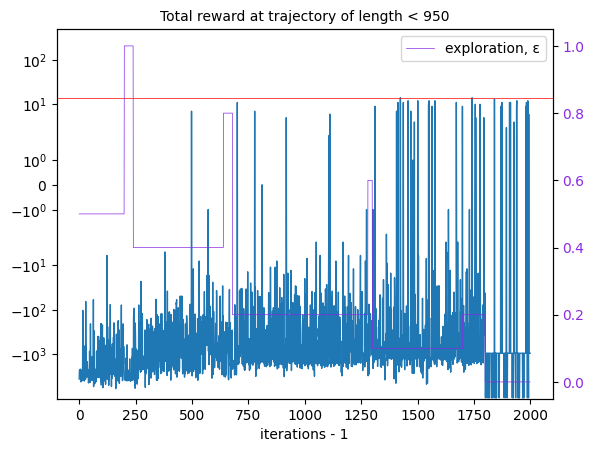

In [9]:
mca = MonteCarloAgent()
# (mca.walk_r(0.7, 5)[0] == mca.walk_gn_test(0.7,5)[0]).any()
# ann_mc = None
# ann_mc = SigmoidalAR(al=0.01)
# ann_mc = ExponentialAR(la=1e-2)
# ann_mc = SteppingAR(n_iterations=1000, steps=((100, 20), (80, 10), (60, 20), (40, 40), (0, 10)))
ann_mc = SteppingAR(n_iterations=2000, steps=((50, 10), (100,2), (40, 20), (80, 2), (20, 30), (60,1), (10, 20), (20, 5), (0, 10)))
mca.fit(n_trajectories=2000, max_length=950, gamma=0.999, eps_d=ann_mc, verbose=True)

In [236]:
T = 50
# res = sarsa.walk(T)
res = qlr.walk(T)
# res = cea.walk(T)
# res = mca.walk(T)
sum(res['r'])
# cea.capture(T)

11

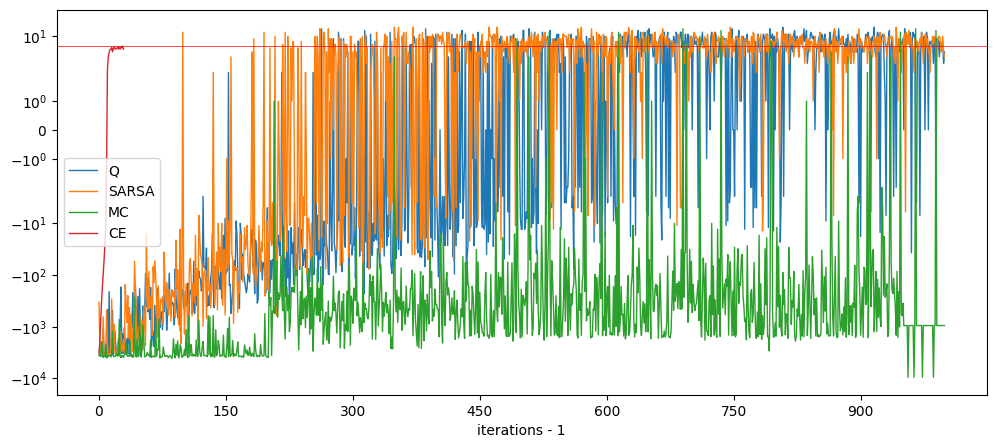

In [42]:
plt.figure(figsize=(12,5))
ax = qlr.learning_curve(logscale=True, label='Q', show_max=False)
ax = sarsa.learning_curve(logscale=True, label='SARSA', ax=ax, show_max=False)
ax = mca.learning_curve(logscale=True, label='MC', ax=ax, show_max=False)
ax = cea.learning_curve(logscale=True, label='CE', ax=ax, show_max=True)

<a id="results"></a>

# Results
Well, I made it shine, nothing to do here. Convergence kinda suxx but whatever...

## Model-free Algorithms
In my implementation, all agents of this type are subclasses of ModelFreeClass, i.e. *greedy policy improvement* method is same and *fit* is almost identical 

I vary hyperparameters throughout a learning process in accordance with several decay rules (also classes, for my convenience); my typical choices are:
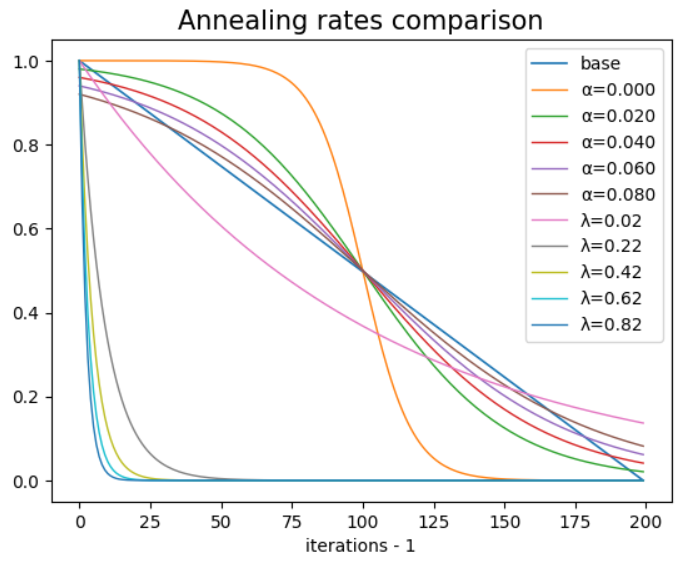

In addition, I've created a step function with as many steps as I wish

I keep $n\_iterations\in [700, 1000]$ and $max\_length=950$ from previous results with this env

When applicable, i also try to decrease $\alpha$ ~ 'learning rate' somehow since policy shouldn't be disturbed towards the end

### SARSA
This one has the 'best' convergence amongst model-frees on this environment

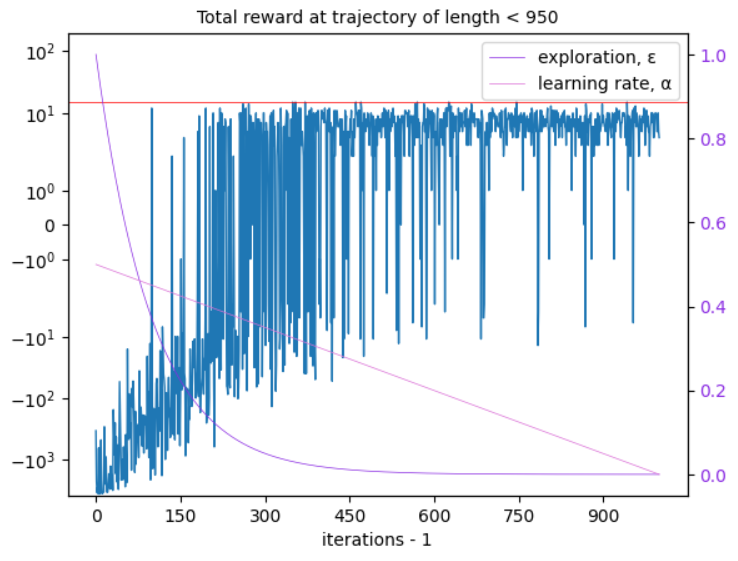

### Q-learning
Quite unstable at the very end, when $\epsilon\to 0$ but anyway

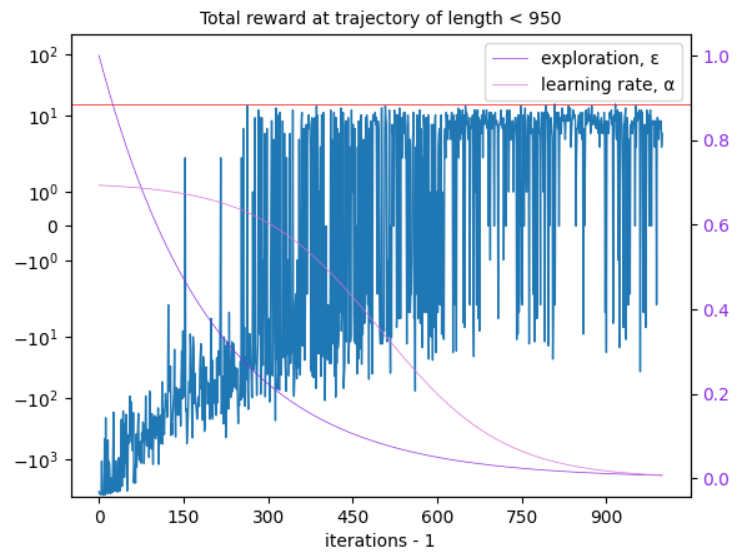

### Monte-Carlo
Hardest. I tried two different approaches for $q(a,s)\longleftrightarrow Q_{sa}$ calculation: vectorized numpy-inspired and recurrent default; I did make sure that they yield identical results for $Q_{sa}$ and $N_{sa}$.

I've tried various annealing rates for eps but the convergence is quite poor and/or slow

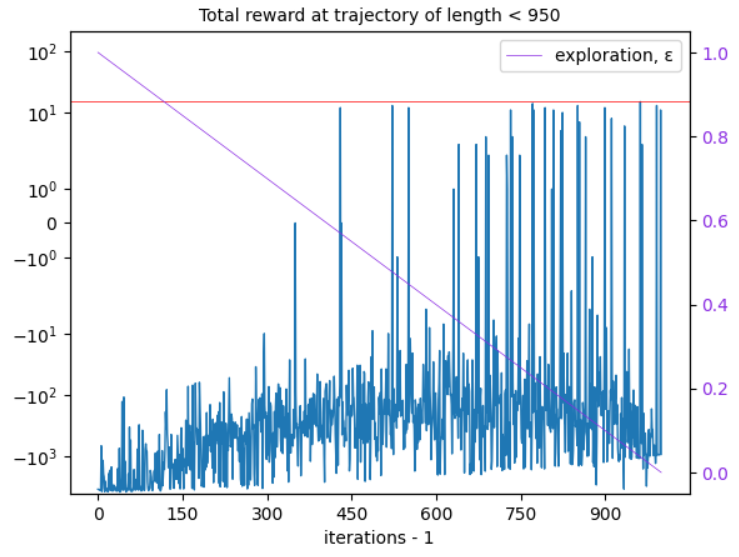
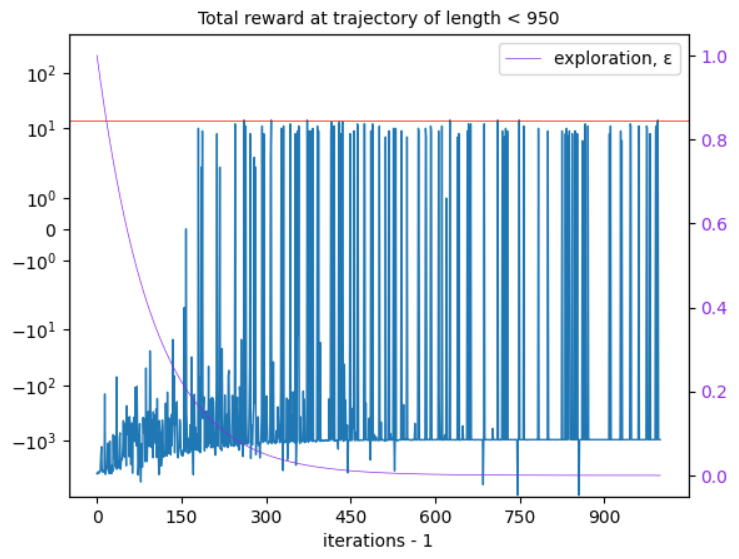
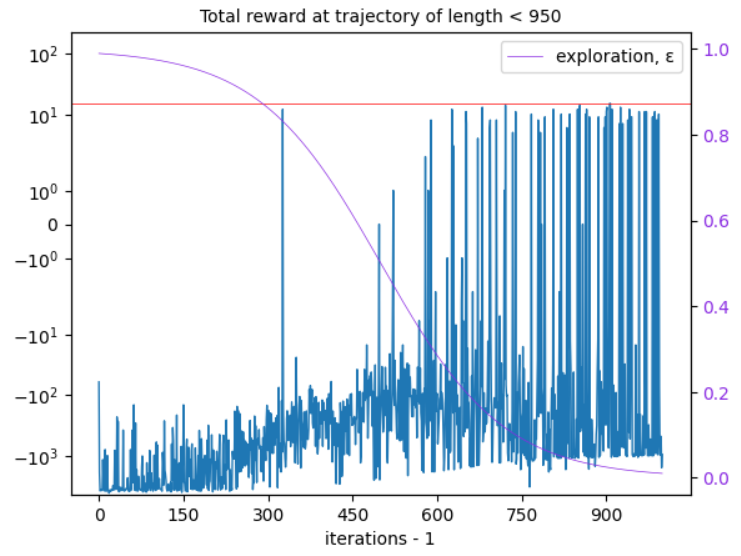
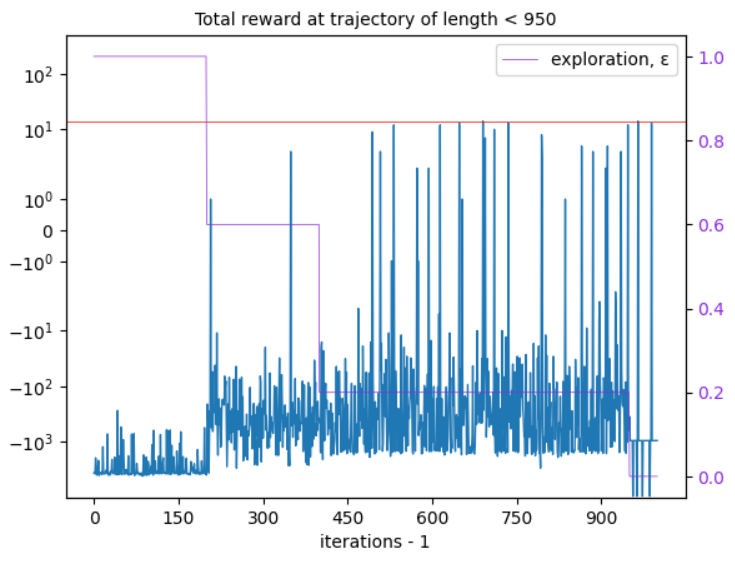
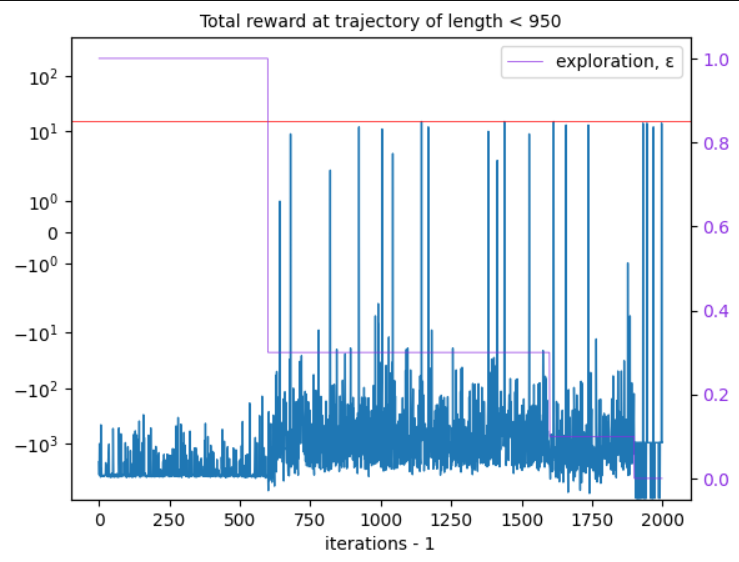

As a possible fix, I came up with an idea of negative masking for unvisited states (instead of zeros) just before Q-matrix is being evaluated by epsilon-greedy policy. 
Otherwise those unknown states are more preferable, skew results, slowing down the whole learning process. That value shouldn't be $-\infty$ but I run out of time so just picked some randoms within -100..-10 range..has yet to be tested

## Cross-Entropy method
In comparison with all those aforementioned, CE algorithm has proven to be faster and stable option for this particular environment (Taxiv3)

Not only because it converges faster (can't judge just by a number of iterations, using time instead), but the whole learning process is descriptive enough; results are reproducible

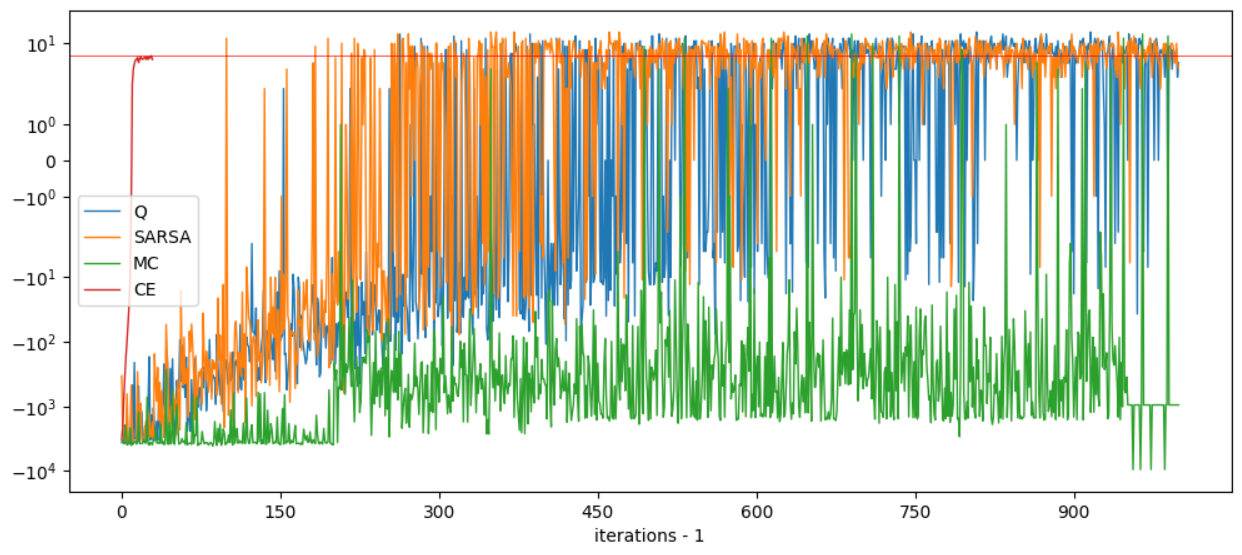